_just_ inference with all parameters from noisy simulation

In [1]:
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit import *
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit.opflow import CircuitSampler


from qiskit.ignis.mitigation.measurement import CompleteMeasFitter # you will need to pip install qiskit-ignis
from qiskit.ignis.mitigation.measurement import complete_meas_cal

from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

In [2]:
anti = -1
L = 5
num_trash = 2

name = "ibmq_antiferro-1D-load_bogota-optimize-20points" # 01.06.2021 experiment
filename = "data/noisy_VQE_maxiter-500_Ising_L5_anti_-1_20" #"data/noisy_VQE_maxiter-100_Ising_L5_anti_-1_20_recycle"
print("filename: ", filename, "notebook name: ", name)

# where to get the simulated thetas values from? needs to contain a thetas_mitigated array
filename_simulated_thetas = 'data/ibmq_antiferro-1D-load_bogota-optimize_thetas-loss-cost_run2.npz'

filename:  data/noisy_VQE_maxiter-500_Ising_L5_anti_-1_20 notebook name:  ibmq_antiferro-1D-load_bogota-optimize-20points


In [17]:
load = True
recompute = False # whether or not to recompute Magnetization, makes sense on device

## Magnetization

In [18]:
L = 5
num_trash = 2
anti = -1

VQE_params = np.load(filename + ".npz", allow_pickle=True)
pick = np.arange(0,len(VQE_params['gx_list']))
gx_list = VQE_params['gx_list'][pick]
gz_list = VQE_params['gz_list'][pick]
opt_params = VQE_params['opt_params'][pick]
Qmags = VQE_params["Qmag"][pick]
Qen = VQE_params["Qen"][pick]
Sen = VQE_params["Sen"][pick]
Smags = VQE_params["Smag"][pick]

gx_vals = np.unique(gx_list)
gz_vals = np.unique(gz_list)

In [19]:
if load:
    temp = np.load("data/" + name + "executed_mags-Es.npz",allow_pickle=True)
    Qmags_executed = temp["Qmags"]

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, '$\\mid M \\mid$')

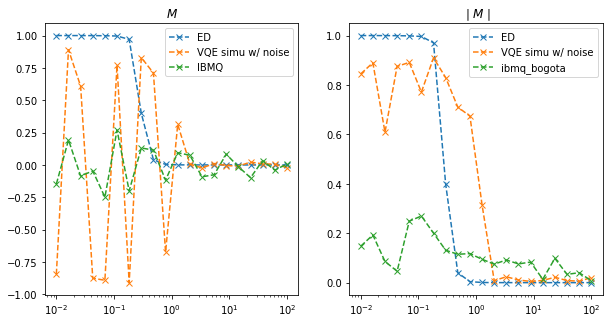

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax = axs[0]
ax.plot(gx_list, Smags,"x--", label="ED")
ax.plot(gx_list, Qmags,"x--", label="VQE simu w/ noise")
ax.set_xscale("log")
if recompute or load:
    ax.plot(gx_list, Qmags_executed,"x--", label="IBMQ")
ax.legend()
ax.set_title("$M$")

ax = axs[1]
ax.plot(gx_list, Smags,"x--", label="ED")
ax.plot(gx_list, abs(Qmags),"x--", label="VQE simu w/ noise")
ax.set_xscale("log")
if recompute or load:
    ax.plot(gx_list, abs(Qmags_executed),"x--", label="ibmq_bogota")
ax.legend()
ax.set_title("$\\mid M \\mid$")

In [21]:
##############################################################################
### II - Training  ###########################################################
##############################################################################

In [25]:
cal_matrix = np.array([[0.982, 0.036, 0.032, 0.003],
 [0.011, 0.959, 0.,    0.036],
 [0.007, 0.001, 0.962, 0.023],
 [0.,    0.004, 0.006, 0.938]]) # this was the one from the experiment

In [26]:
phis = opt_params

In [27]:
# translate to Rikes naming

gxs = gx_list
gzs = gz_list

## Run 1

In [30]:
phys_params= [0]

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


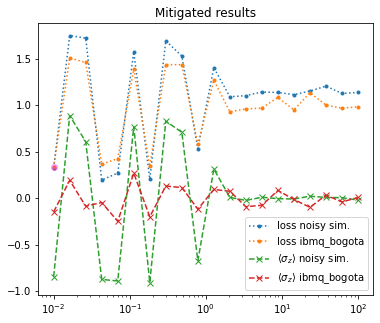

In [34]:
fig, ax = plt.subplots(ncols=1,figsize=(6,5))
ax.set_title("Mitigated results")
cost = np.load("data/" + "ibmq_antiferro-1D-load_simu" + "_thetas-loss-cost_run1.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="loss noisy sim.")

cost = np.load("data/" + name + "_thetas-loss-cost_run1.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="loss ibmq_bogota")

ax.plot(gx_list, Qmags,"x--", label="$\\langle \\sigma_z \\rangle$ noisy sim.")
ax.plot(gx_list, Qmags_executed,"x--", label="$\\langle \\sigma_z \\rangle$ ibmq_bogota")
ax.set_xscale("log")
for p in phys_params:
    ax.plot(gx_list[p],cost[p],"o",alpha=0.3,color="magenta")
ax.legend()

In [36]:
phys_params = [-1]

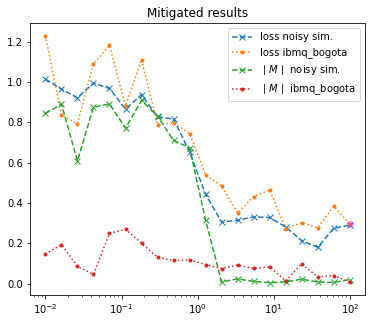

In [44]:
fig, ax = plt.subplots(ncols=1,figsize=(6,5))
ax.set_title("Mitigated results")
cost = np.load("data/" + "ibmq_antiferro-1D-load_simu" + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,"x--", label="loss noisy sim.")

cost = np.load("data/" + name + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="loss ibmq_bogota")

ax.plot(gx_list, abs(Qmags),"x--", label="$\\mid M \\mid$ noisy sim.")
ax.plot(gx_list, abs(Qmags_executed),".:", label="$\\mid M \\mid$ ibmq_bogota")
ax.set_xscale("log")
for p in phys_params:
    ax.plot(gx_list[p],cost[p],"o",alpha=0.3,color="magenta")
ax.legend()

# Main plot

In [65]:
name

'ibmq_antiferro-1D-load_bogota-optimize-20points'

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


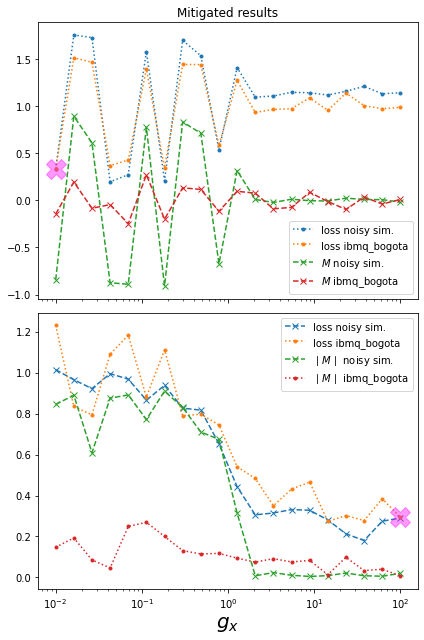

In [64]:
fig, axs = plt.subplots(nrows=2,figsize=(6,9),sharex=True)
ax = axs[0]
ax.set_title("Mitigated results")
cost = np.load("data/" + "ibmq_antiferro-1D-load_simu" + "_thetas-loss-cost_run1.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="loss noisy sim.")

cost = np.load("data/" + name + "_thetas-loss-cost_run1.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="loss ibmq_bogota")

ax.plot(gx_list, Qmags,"x--", label="$M$ noisy sim.")
ax.plot(gx_list, Qmags_executed,"x--", label="$M$ ibmq_bogota")
ax.set_xscale("log")
ax.plot(gx_list[0],cost[0], "X",markersize=20,alpha=0.4,color="magenta")

ax = axs[1]
cost = np.load("data/" + "ibmq_antiferro-1D-load_simu" + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,"x--", label="loss noisy sim.")

cost = np.load("data/" + name + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="loss ibmq_bogota")

ax.plot(gx_list, abs(Qmags),"x--", label="$\\mid M \\mid$ noisy sim.")
ax.plot(gx_list, abs(Qmags_executed),".:", label="$\\mid M \\mid$ ibmq_bogota")
ax.set_xscale("log")
ax.plot(gx_list[-1],cost[-1],"X",markersize=20,alpha=0.4,color="magenta")
for ax in axs:
    ax.legend()
axs[-1].set_xlabel("$g_x$", fontsize=20)
plt.tight_layout()
plt.savefig("plots/" + name + "_mainplot.png")
plt.savefig("plots/" + name + "_mainplot.pdf")